In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
S, P = np.load("../data/dataset.npy")
molecules = np.load("../data/molecules.npy")

In [4]:
def extract_triu(A):
    """Extracts the upper triangular part of the matrix.
    Input can be matrix, will be reshaped if it is not.
    """
    return A.reshape(dim, dim)[np.triu_indices(dim)]

def reconstruct_from_triu(A_flat):
    """Reconstructus the full symmetric matrix (dim x dim, not
    flattened out) from the flattend elements of the upper 
    triag of a symmetric matrix!"""
    result = np.zeros((dim, dim))
    result[np.triu_indices(dim)] = A_flat
    return result + result.T - np.diag(np.diag(result))


In [5]:
from SCFInitialGuess.utilities.dataset import Dataset

dim = 26
dim_triu = int(dim * (dim + 1) / 2)

ind_cut = 150
index = np.arange(200)
np.random.shuffle(index)

S_triu = list(map(extract_triu, S))
P_triu = list(map(extract_triu, P))

S_test = np.array(S_triu)[index[150:]]
P_test = np.array(P_triu)[index[150:]]
molecules_test = [molecules[index[i]] for i in range(150, 200)]

S_train = np.array(S_triu)[index[:150]]
P_train = np.array(P_triu)[index[:150]]
molecules_train = [molecules[index[i]] for i in range(150)]

dataset = Dataset(np.array(S_train), np.array(P_train), split_test=0.0)

dataset.testing = (Dataset.normalize(S_test, mean=dataset.x_mean, std=dataset.x_std)[0], P_test)

[-] 2018-03-28 18:07:33: Data set normalized. Mean value std: 0.008398694002024365


In [6]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer
from SCFInitialGuess.nn.cost_functions import RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim_triu, 400, 400, 400, 400, dim_triu]),
    cost_function=RegularizedMSE(alpha=1e-7),
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3)
)

trainer.setup()
network, sess = trainer.train(
    dataset,
    convergence_threshold=1e-7
)
graph = trainer.graph

[-] 2018-03-28 18:07:33: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-28 18:07:33: Setting up the training in the target graph ...
[-] 2018-03-28 18:07:33: network ...
[-] 2018-03-28 18:07:33: error function ...
[-] 2018-03-28 18:07:33: cost function ...
[-] 2018-03-28 18:07:35: training step
[-] 2018-03-28 18:07:36: Starting network training ...
[ ] 2018-03-28 18:07:36: Val. Cost: 9.536E-02. Error: 9.536E-02. Diff: 1.0E+10
[ ] 2018-03-28 18:07:48: Val. Cost: 2.556E-04. Error: 2.518E-04. Diff: 9.5E-02
[ ] 2018-03-28 18:07:59: Val. Cost: 1.245E-04. Error: 1.205E-04. Diff: 1.3E-04
[ ] 2018-03-28 18:08:09: Val. Cost: 8.360E-05. Error: 7.951E-05. Diff: 4.1E-05
[ ] 2018-03-28 18:08:19: Val. Cost: 2.836E-05. Error: 2.416E-05. Diff: 5.5E-05
[ ] 2018-03-28 18:08:30: Val. Cost: 2.135E-05. Error: 1.714E-05. Diff: 7.0E-06
[ ] 2018-03-28 18:08:41: Val. Cost: 2.380E-05. Error: 1.960E-05. Diff: 2.5E-06
[ ] 2018-03-28 18:08:51: Val. Cost: 1.611E-05. Error: 1.185E-05

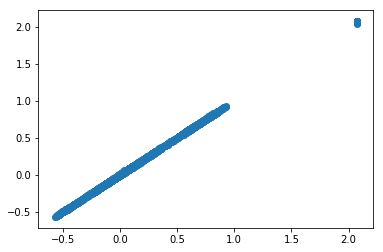

In [7]:
#from SCFInitialGuess.utilities.analysis import prediction_scatter
import matplotlib.pyplot as plt

with graph.as_default():
    plt.scatter(
        dataset.testing[1].flatten(), 
        network.run(sess, dataset.testing[0]).flatten()
    )
plt.show()

In [8]:
def mc_wheeny_purification(p,s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return (3 * np.dot(np.dot(p, s), p) - np.dot(np.dot(np.dot(np.dot(p, s), p), s), p)) / 2

def multi_mc_wheeny(p, s, n_max=4):
    for i in range(n_max):
        p = mc_wheeny_purification(p, s)
    return p

def idemp_error(p, s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return np.mean(np.abs(np.dot(np.dot(p, s), p) - 2 * p))

In [9]:
P_NN_multi = []
for (s, p) in zip(*dataset.testing):
#for (s, p) in zip(S_test, P_test):
    
    #s_norm = s.reshape(1, dim**2)
    s_raw = reconstruct_from_triu(dataset.inverse_input_transform(s))
    p_raw = reconstruct_from_triu(p)
    
    
    print("Orig:         {:0.3E}".format(idemp_error(p_raw, s_raw))) 
    
    with graph.as_default():
        p_nn = reconstruct_from_triu(network.run(sess, s.reshape(1, dim_triu)))
        
    print("NN:           {:0.3E}".format(idemp_error(p_nn, s_raw)))
    print("NN pruified:  {:0.3E}".format(idemp_error(mc_wheeny_purification(p_nn, s_raw), s_raw)))
    p_nn_multi = multi_mc_wheeny(p_nn, s_raw, n_max=5)
    
    P_NN_multi.append(extract_triu(p_nn_multi))
    print("NN multified: {:0.3E}".format(idemp_error(p_nn_multi, s_raw))) 
    print("Error NN before: {:0.3E}".format(np.mean(np.abs(p_raw - p_nn))))
    print("Error NN multifed:  {:0.3E}".format(np.mean(np.abs(p_raw - p_nn_multi))))
    print("---------------------------")

Orig:         3.217E-16
NN:           2.489E-03
NN pruified:  6.737E-05
NN multified: 7.470E-17
Error NN before: 1.872E-03
Error NN multifed:  1.304E-03
---------------------------
Orig:         3.060E-16
NN:           2.836E-03
NN pruified:  1.058E-04
NN multified: 7.760E-17
Error NN before: 2.256E-03
Error NN multifed:  1.595E-03
---------------------------
Orig:         3.518E-16
NN:           2.293E-03
NN pruified:  6.255E-05
NN multified: 7.491E-17
Error NN before: 1.805E-03
Error NN multifed:  1.216E-03
---------------------------
Orig:         3.180E-16
NN:           2.371E-03
NN pruified:  7.644E-05
NN multified: 6.387E-17
Error NN before: 2.037E-03
Error NN multifed:  1.507E-03
---------------------------
Orig:         3.405E-16
NN:           3.003E-03
NN pruified:  1.164E-04
NN multified: 6.704E-17
Error NN before: 2.557E-03
Error NN multifed:  1.887E-03
---------------------------
Orig:         3.254E-16
NN:           1.923E-03
NN pruified:  5.119E-05
NN multified: 7.609E-17

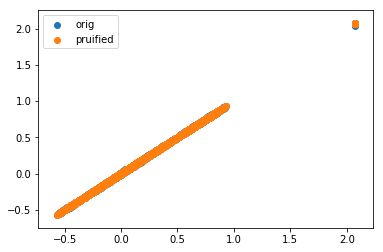

In [10]:
with graph.as_default():
    plt.scatter(
        dataset.testing[1].flatten(), 
        network.run(sess, dataset.testing[0]).flatten(),
        label="orig"
    )
    plt.scatter(
        dataset.testing[1].flatten(), 
        np.array(P_NN_multi).flatten(),
        label="pruified"
    )
plt.legend()
plt.show()

In [11]:
from pyscf.scf import hf
from SCFInitialGuess.utilities.plotutils import prediction_scatter

keys = ["noise", "nn", "nn_purified"]

iterations = {}
for k in keys:
    iterations[k] = []

for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    
    guesses = {}

    s_raw = hf.get_ovlp(mol)
    s_norm = dataset.input_transformation(extract_triu(s_raw)).reshape(1, dim_triu)
    
        
    # P_actual wi noise
    p_raw = reconstruct_from_triu(p)
    p_noise = p_raw + np.random.randn(dim, dim) * 1e-2
    guesses["noise"] = p_noise
    
    
    with graph.as_default():
        p_orig = reconstruct_from_triu(network.run(sess, s_norm)).astype('float64')
        
    guesses["nn"] = p_orig


    p_purified = multi_mc_wheeny(p_orig, s_raw, n_max=5)
    guesses["nn_purified"] = p_purified

    # check errors
    print("Accuracy (MSE):")
    print(" -Noise: {:0.3E}".format(np.mean(np.abs(p_raw - p_noise)**2)))
    print(" -NN:    {:0.3E}".format(np.mean(np.abs(p_raw - p_orig)**2)))
    print(" -Pruif: {:0.3E}".format(np.mean(np.abs(p_raw - p_purified)**2)))

    print("Idempotency:")
    print(" -Noise: {:0.3E}".format(idemp_error(p_noise, s_raw)))
    print(" -Orig:  {:0.3E}".format(idemp_error(p_orig, s_raw)))
    print(" -Purif: {:0.3E}".format(idemp_error(p_purified, s_raw)))

    
    
    for (key, guess) in guesses.items():
        mf = hf.RHF(mol)
        mf.diis = None
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations[key].append(mf.iterations)

        
for k in keys:
    iterations[k] = np.array(iterations[k])

OSError: dlopen: cannot load any more object with static TLS

In [ ]:
for key, val in iterations.items():
    print(key + ": " + str(val.mean()))

In [ ]:
from SCFInitialGuess.utilities.plotutils import iterations_histogram

for key, val in iterations.items():
    hist, bins = np.histogram(val)
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=key)
    
plt.legend()
plt.show()
plt.show()